In [1]:
# KNN Regression model to be trained
# with various values of k

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor as KNN
import mltools as ml

In [2]:
# Shuffling
def shuffle_rows(arr,rows):
    np.random.shuffle(arr[rows[0]:rows[1]+1])

def MSE(Y, Yhat):
    return np.sum((Y-Yhat)**2)

data = np.genfromtxt('final.csv', delimiter = ",")

shuffle_rows(data[1:data.shape[0]-1], [0,data.shape[0]-1])
X = data[1:data.shape[0]-1, 1:7]
Y = data[1:data.shape[0]-1, 7:8]
tr = int(X.shape[0]*0.8)
te = X.shape[0] - tr
Xtr = X[0:tr]
Xte = X[tr:tr+te]
Ytr = Y[0:tr]
Yte = Y[tr:tr+te]

k_values = np.arange(1, 99, 3, dtype = int)
errors_te = []
errors_tr = []
for k in k_values:
    knn = KNN(n_neighbors=k)
    knn.fit(Xtr, Ytr)
    Yhat_te = knn.predict(Xte)
    Yhat_tr = knn.predict(Xtr)
    # print("K:", k, "MSE:", MSE(Yte, Yhat_te))
    errors_te.append(MSE(Yte, Yhat_te))
    errors_tr.append(MSE(Ytr, Yhat_tr))

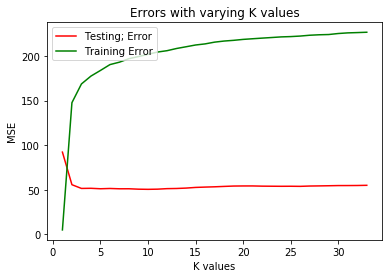

In [3]:
plt.title("Errors with varying K values")
plt.plot(np.arange(1, 34), errors_te, color = "red", label= "Testing; Error")
plt.plot(np.arange(1, 34), errors_tr, color = "green", label="Training Error")
plt.xlabel("K values")
plt.ylabel("MSE")
plt.legend(loc="upper left")
plt.show()

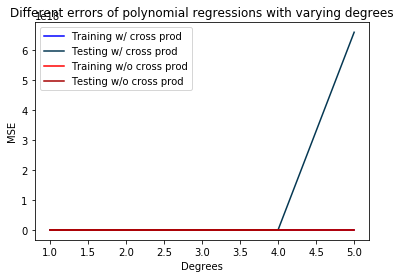

In [5]:
# Polynomial linear regression model with various degrees and features
from sklearn.preprocessing import PolynomialFeatures as PolyFeat
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV


def MSE(Y, Yhat):
    return np.sum((Y-Yhat)**2)/Y.shape[0]

# Preparing training and testin data
data = np.genfromtxt('final.csv', delimiter = ",")

# Deleting some of the features

#data = np.delete(data, 6, 1)   # Rain
#data = np.delete(data, 5, 1)   # Wind Speed
#data = np.delete(data, 4, 1)   # Temperature
#data = np.delete(data, 3, 1)   # Elevation
#data = np.delete(data, 2, 1)   # Longitude
#data = np.delete(data, 1, 1)   # Latitude

features = ["Latitude", "Longitude", "Elevation", "Temperature", "WindSpeed", "Rain"]
X = data[1:data.shape[0]-1, 1:7]
Y = data[1:data.shape[0]-1, 7:8]
tr = int(X.shape[0]*0.8)
te = X.shape[0] - tr
Xtr = X[0:tr]
Xte = X[tr:tr+te]
Ytr = Y[0:tr]
Yte = Y[tr:tr+te]

# Making copy of data with order of the features according to ranking 1
ranking1 = ["Latitude", "Temperature", "Rain", "Longitude", "Wind Speed", "Elevation"]
permutation1 = [0,3,5,1,4,2]
perm_mat1 = np.zeros((6, 6))
for idx, i in enumerate(permutation1):
    perm_mat1[idx, i] = 1
ranking1_Xtr = np.dot(Xtr, perm_mat1)
ranking1_Xte = np.dot(Xte, perm_mat1)

# Making copy of data with order of the features according to ranking 2
ranking2 = ["Temperature", "Longitude", "Rain", "Wind Speed", "Elevation", "Latitude"]
permutation2 = [5,1,4,0,3,2]
perm_mat2 = np.zeros((6, 6))
for idx, i in enumerate(permutation2):
    perm_mat2[idx, i] = 1
ranking2_Xtr = np.dot(Xtr, perm_mat2)
ranking2_Xte = np.dot(Xte, perm_mat2)

def getErrorsMono(Xtr, Ytr, Xte, Yte):
    # Given training and testing sets, gives errors on degrees of 1 to 3
    # doesn't include cross products
    degrees = np.arange(1, 6, 1, dtype = int)
    errors_te = []
    errors_tr = []
    for d in degrees:
        XtrP = ml.transforms.fpoly_mono(Xtr, d)
        XteP = ml.transforms.fpoly_mono(Xte, d)
        #lin = ml.linear.linearRegress()
        #lin.train(Xtr, Ytr)
        lin = LinearRegression().fit(XtrP, Ytr)
        Yhat_te = lin.predict(XteP)
        Yhat_tr = lin.predict(XtrP)
        errors_te.append(MSE(Yte, Yhat_te))
        errors_tr.append(MSE(Ytr, Yhat_tr))
    return (errors_tr, errors_te)

def getErrors(Xtr, Ytr, Xte, Yte):
    # Given training and testing sets, gives errors on degrees of 1 to 3
    # includes cross products
    degrees = np.arange(1, 6, 1, dtype = int)
    errors_te = []
    errors_tr = []
    for d in degrees:
        XtrP = ml.transforms.fpoly(Xtr, d)
        XteP = ml.transforms.fpoly(Xte, d)
        lin = LinearRegression(n_jobs=2).fit(XtrP, Ytr)
        #lin = ml.linear.linearRegress()
        #lin.train(Xtr, Ytr)
        Yhat_te = lin.predict(XteP)
        Yhat_tr = lin.predict(XtrP)
        errors_te.append(MSE(Yte, Yhat_te))
        errors_tr.append(MSE(Ytr, Yhat_tr))
    return (errors_tr, errors_te)

def trainOnRanking(ranking_Xtr, Ytr, ranking_Xte, Yte):
    # Trains the model on top n features and for various degrees
    errors_tr = []
    errors_te = []
    for i in range(6):
        temp_ranking_Xtr = ranking_Xtr[:,0:(i+1)]
        temp_ranking_Xte = ranking_Xte[:,0:(i+1)]
        print("ranking_Xtr shape:", temp_ranking_Xtr.shape)
        errors = getErrors(temp_ranking_Xtr,Ytr,temp_ranking_Xte,Yte)
        print("errors shape:", len(errors[0]))
        errors_tr.append(errors[0])
        errors_te.append(errors[1])
    print(errors_tr)
    return errors_tr, errors_te


err_cross_tr = []
err_cross_te = []
err_tr       = []
err_te       = []

err_cross_tr, err_cross_te = getErrors(Xtr, Ytr, Xte, Yte)
err_tr, err_te         = getErrorsMono(Xtr, Ytr, Xte, Yte)

xlen = np.arange(1, 6, 1)

plt.title("Different errors of polynomial regressions with varying degrees")
plt.plot(xlen, err_cross_tr, label = "Training w/ cross prod", color = "blue")
plt.plot(xlen, err_cross_te, label = "Testing w/ cross prod", color = "#053853")
plt.plot(xlen, err_tr, label = "Training w/o cross prod", color = "red")
plt.plot(xlen, err_te, label = "Testing w/o cross prod", color = "#A50000")
plt.xlabel("Degrees")
plt.ylabel("MSE")
plt.legend(loc="upper left")
plt.show()